# Визуальный анализ данных

Набор данных, используемый в данном материале, может быть скачан по ссылке: https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results (требуется авторизация).

Импорт необходимых библиотек:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Краткое описание библиотек.
Matplotlib — библиотека для визуализации данных двумерной (2D) и трехмерной (3D) графикой. Получаемые изображения могут быть использованы в качестве иллюстраций в публикациях.
Matplotlib написан и поддерживался в основном Джоном Хантером (англ. John Hunter) и распространяется на условиях BSD-подобной лицензии. Генерируемые в различных форматах изображения могут быть использованы в интерактивной графике, в научных публикациях, графическом интерфейсе пользователя, веб-приложениях, где требуется построение диаграмм. В документации автор признаётся, что Matplotlib начинался с подражания графическим командам MATLAB, но является независимым от него проектом.

Seaborn — это более высокоуровневое API на базе библиотеки matplotlib. Seaborn содержит более адекватные дефолтные настройки оформления графиков. Также в библиотеке есть достаточно сложные типы визуализации, которые в matplotlib потребовали бы большого количество кода.

Путь к данным:

In [3]:
path = 'athlete_events.csv'

Считывание данных:

In [4]:
data = pd.read_csv(path)

Сразу заполним значением 0 ячейки с "nan"

In [5]:
data.fillna(0, inplace = True)

Посмотрим на "голову" набора данных

In [6]:
data.head(1)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,0


## Stackplot
Первый график, который будет построен - это Stackplot (надставленные области). Чтобы построить график, методу stackplot необходимо всего два аргумента: массив с координатами x и массивы c y координатами линий. Вот только отсчет y координат каждой последующей линии ведется от y координат предыдущей линии.
В качестве примера будет рассмотрено количество золотых медалей, которое получила команда России начиная с 1994 года. Первый массив - это количество медалей за каждый год. Второй массив - это количество медалей за предыдущие года. 

In [71]:
#Получение золотых медалей с разбивкой по годам
medals = data[(data['NOC'] == 'RUS') & (data['Medal'] == 'Gold')]['Year'].value_counts()
#Список годов
years = np.array(medals.sort_index().index)
#Удаление года, который выходит за предел рассматриваемого периода
medals = medals.drop(1908)
#Массив для суммирования по годам (второй массив)
medals_stack = np.array(medals.sort_index())
#Временный массив, который используется для сдвига
medals_temp = np.array(medals.sort_index())
#Заполнение второго массива
for i in range(1, len(medals_stack)):
    medals_stack[i] = medals_temp[i-1]
    if i>1:
        medals_stack[i] += medals_stack[i-1]
#В первый рассматриваемый год накопленных медалей не было
medals_stack[0] = 0
#Массив данных для stackplot
medals_array = np.array([medals.sort_index(), medals_stack])

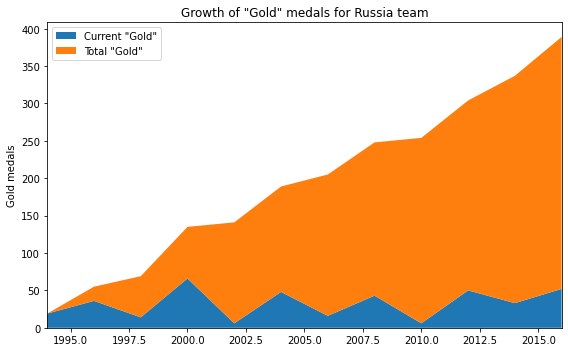

In [72]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.stackplot(medals.sort_index().index, medals_array, labels=['Current "Gold"', 'Total "Gold"'])
ax.set_title('Growth of "Gold" medals for Russia team')
ax.legend(loc='upper left')
ax.set_ylabel('Gold medals')
ax.set_xlim(left = medals.index.min(), right = medals.index.max())
fig.tight_layout()
 
plt.show()

## Dataframe.plot
Рассмотрим самый простой и зачастую удобный способ визуализировать данные из pandas DataFrame — это функция plot. Реализация функции plot в pandas основана на библиотеке matplotlib.
Для примера построим график, показывающий количество разыгранных золотых медалей по годам. Для этого будут выбраны только строки, в который колонка 'Medal' = 'Gold'. Подсчитано их количество, данные отсортированы по индексу (по годам) и вызвана функция plot.

<AxesSubplot:>

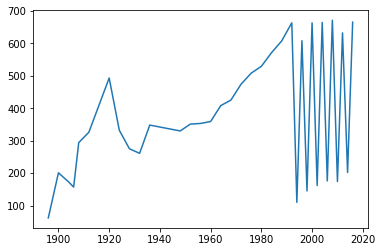

In [73]:
data[(data['Medal'] == 'Gold')]['Year'].value_counts().sort_index().plot()

Как видно из полученного графика, начиная с 1994 года значения начинают сильно "прыгать". В случае с рассматриваемым набором данных причину этих "скачков" легко установить - начиная с 1994 года зимние игры начали проводиться через 2 года после летних. Поэтому после 1994 года на графике показаны отдельно зимние и отдельно летние игры. 
В случае с реальной производственной (или иной) задачей такой график может показать - в каких строках искать аномалии в данных.
Следующий график показывает количество разыгранных золотых медалей только на летних играх.

<AxesSubplot:>

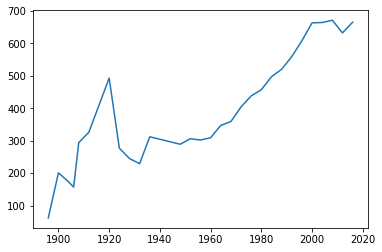

In [74]:
data[(data['Medal'] == 'Gold') & (data['Season'] == 'Summer')]['Year'].value_counts().sort_index().plot()

В качестве еще одного примера проведем анализ количества проводимых соревнований (Events) по годам. Рассматривать будем сумму соревнований летних и зимних игр. Для этого требуется предварительная подготовка данных. В отделный объект list будет записываться количество уникальных соревнований. Отдельно требуется обработка данных после 1994 года, когда зимние и летние игры начали проводиться в разные годы.

In [75]:
#Список всех годов, когда игры проводились
d = data['Year'].unique()
d.sort()
#создание объекта list с количеством уникальных видов спорта по годам
uniq_events = []
for i in range(0, len(d)-1):
    #Если до 1994 - зимние и летние проводятся в один год
    if d[i]<1994:
        uniq_events.append(data[data['Year']==d[i]]['Event'].nunique())
    else:
        #После 1994 - зимние и летние приходится складывать
        for j in range(i, len(d)-1, 2):
            uniq_events.append(data[data['Year']==d[j]]['Event'].nunique() + data[data['Year']==d[j+1]]['Event'].nunique())
        break
#Удаление годов только с зимними играми
d = np.delete(d, [33, 31, 29, 27, 25, 23])
events_array = pd.Series(data=uniq_events, index=d, dtype=None, name=None, copy=False, fastpath=False)

Построение графика.

<AxesSubplot:>

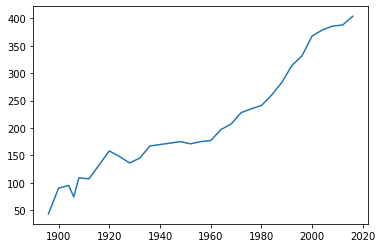

In [76]:
events_array.plot()

## Dataframe.plot: kind
Функция plot, применяемая к Dataframe или Series, имеет набор параметров. Полный набор параметров можно посмотреть по ссылке - https://pandas-docs.github.io/pandas-docs-travis/reference/api/pandas.DataFrame.plot.html
Одним из ключевых параметров является kind - тип графика. По умолчанию применяется тип "line" : line plot (установлен по умолчанию).
При использовании типа графика "bar" - линия будет заменена на столбчатую диаграмму. Где каждому году будет соответствовать столбец определенной высоты. Выводимый график может быть тонко настроен с использованием параметров. Например, на следующем графике выбран размер шрифта равный 26 и угол наклона надписей по оси Х равный 45 градусам.

<AxesSubplot:>

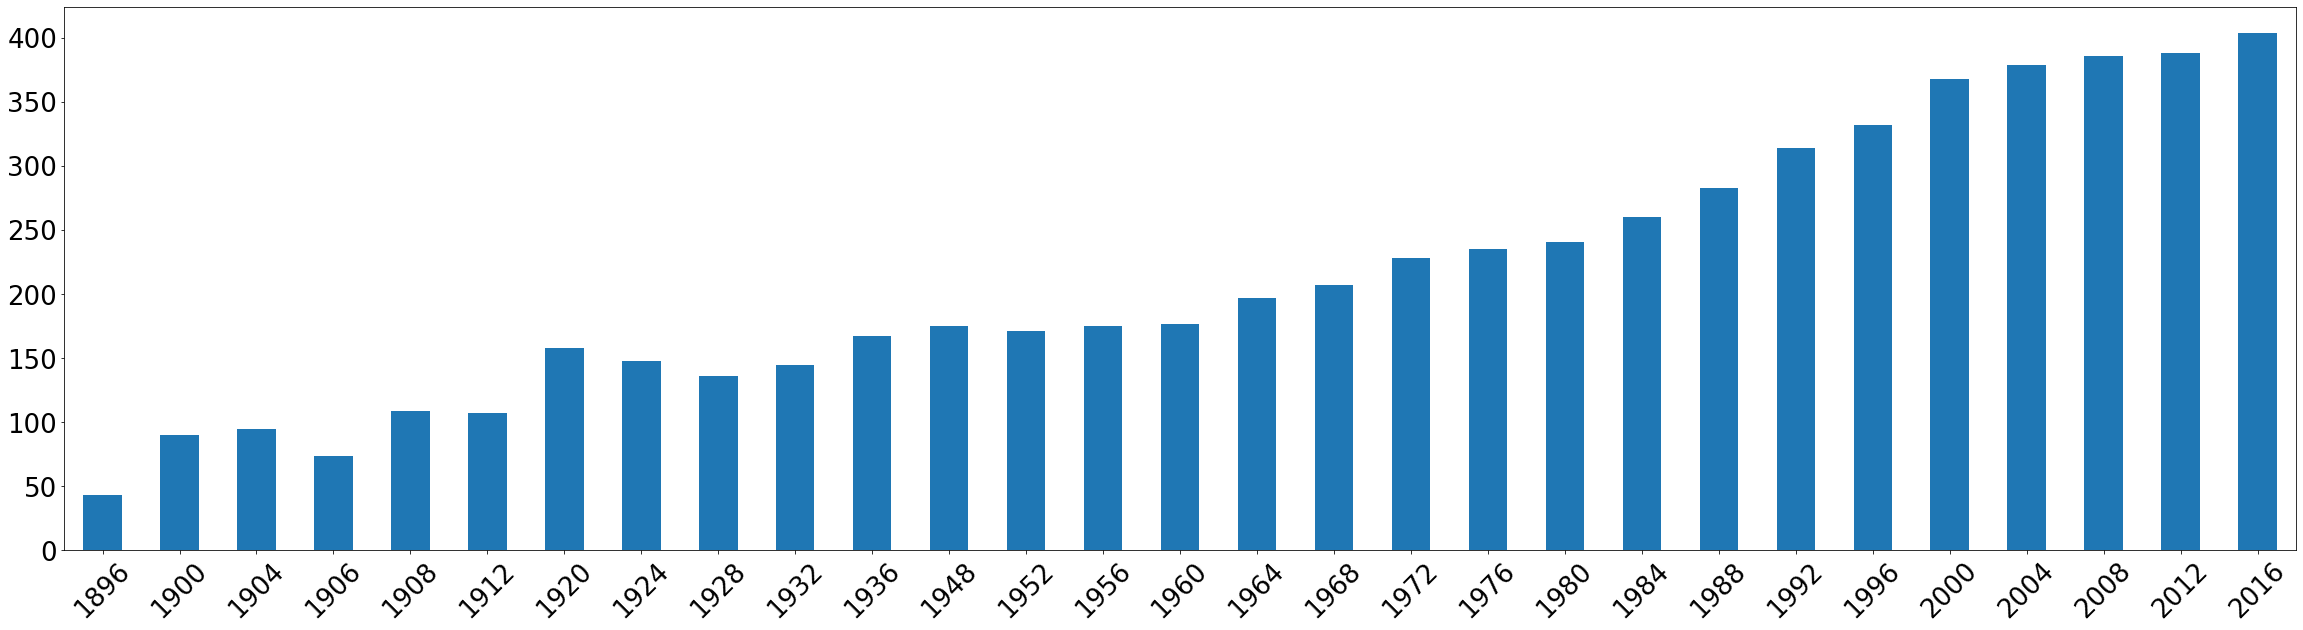

In [77]:
events_array.plot(kind='bar', figsize = [40,10], rot = 45, fontsize = 26)

Одним из важных для анализа статистических взаимосвязей является тип графика "density", который отображает плотность распределения наблюдаемых значений.

<AxesSubplot:ylabel='Density'>

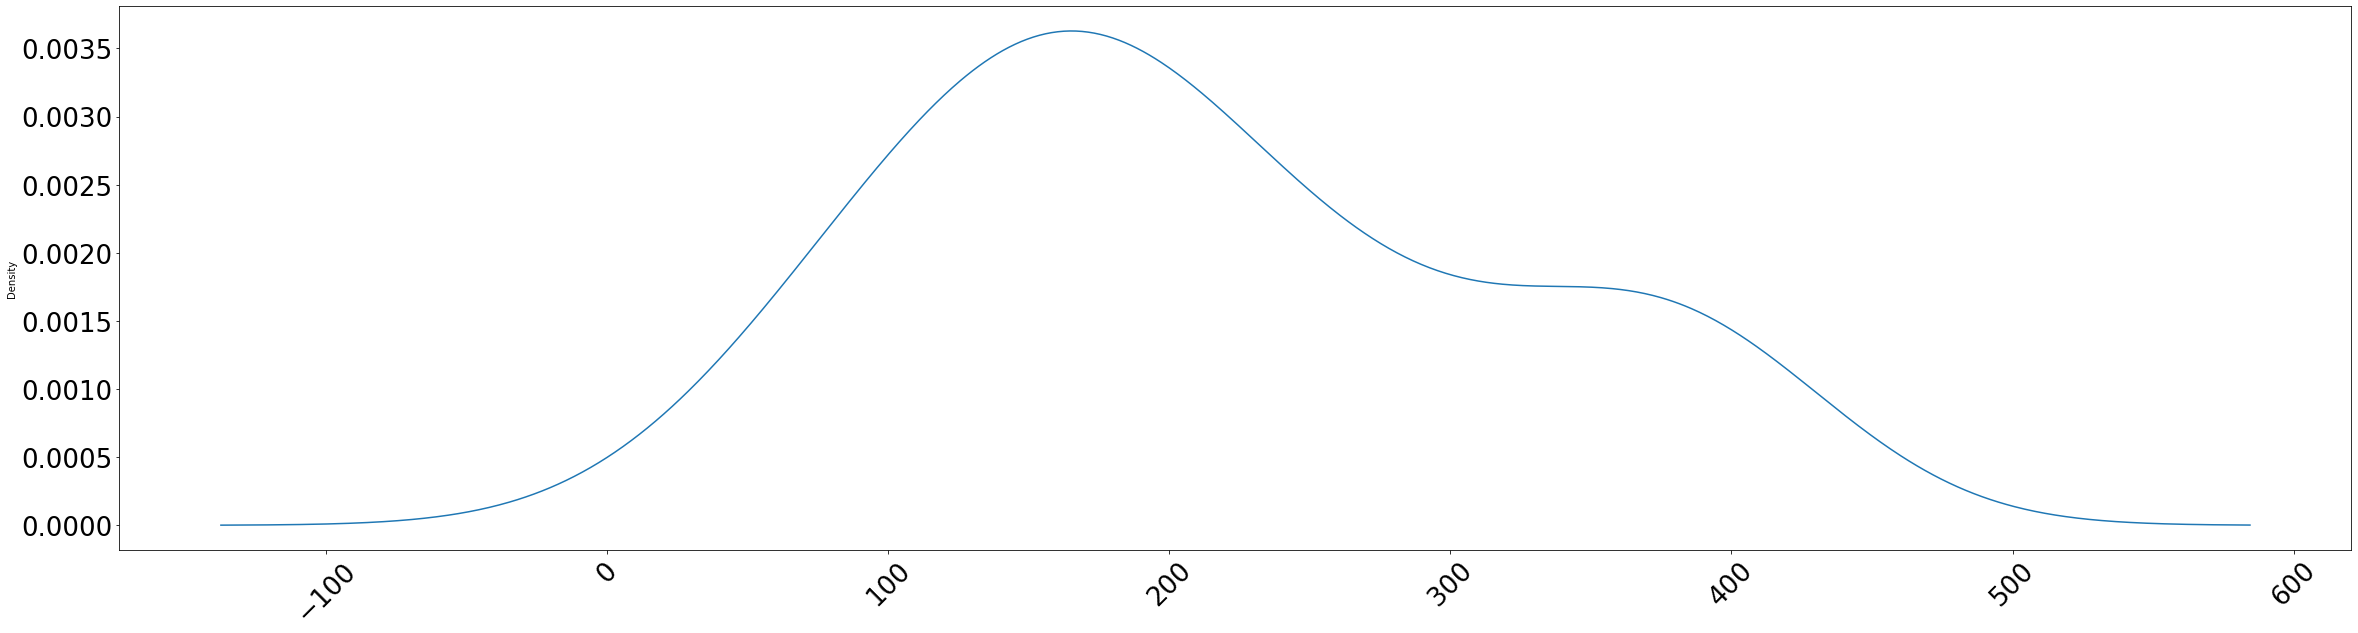

In [78]:
events_array.plot(kind='density', figsize = [40,10], rot = 45, fontsize = 26)

Еще одним примером типа графика является круговая диаграмма.

<AxesSubplot:ylabel='None'>

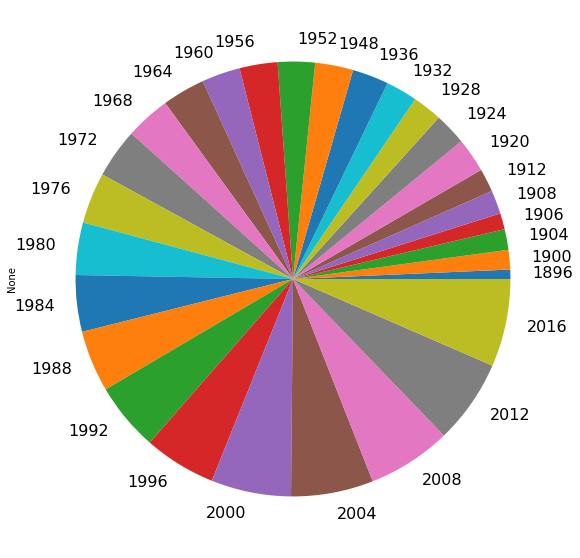

In [79]:
events_array.plot(kind='pie', figsize = [40,10], fontsize = 16)

В качестве еще одного примера построения графиков рассмотрено количество медалей, завоеванных командами. В первую очередь создается новый Dataframe, в который записываются только строки со значением медалей отличных от 0 (ранее все "nan" были заменены на 0). Полученные данные группируются по командам и типам медалей. Для каждой группы команда/тип медали ставится в соответствие количество медалей. Далее полученные данные сортируются по убыванию и строится график из первых 10 значений.

<AxesSubplot:xlabel='NOC,Medal'>

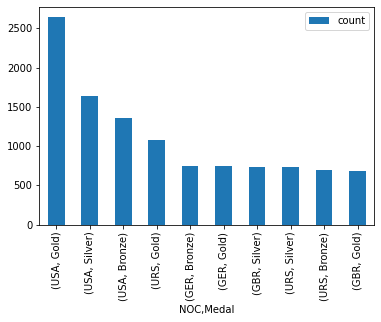

In [80]:
teams_df = data.loc[data['Medal']!=0, :].groupby(['NOC', 'Medal'])[['Medal']].count()
teams_df.columns = ['count']
teams_df.sort_values(by='count', ascending=False).head(10).plot(kind='bar')


## Seaborn
Рассмотрим некоторые возможности построения графиков с применением seaborn.
Первый рассматриваемый график - countplot. Данный график отображает количественные показатели признаков.
На следующем графике представлено общее количество разыгранных медалей.
Для того, чтобы явно увидеть, что количество золотых медалей превышает количество серебряных и бронзовых, необходимо раскоментировать строку с заданием размера графика.

<AxesSubplot:xlabel='Medal', ylabel='count'>

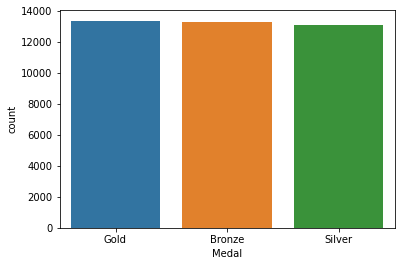

In [81]:
#plt.figure(figsize=(15,16))
sns.countplot(data[data['Medal']!=0]['Medal'])

В качестве следующего примера проведен анализ завоеванных медалей по возрастным группам. В первую очередь создан новый признак - возрастная категория ('age_cat'), которая объединяет в разные группы: спортсменов до 18 лет, от 18 до 25лет, от 25 до 35 лет и свыше 35 лет. Далее вызвано построение countplot, в который в качестве агрументов передан признак 'Medal' и новый признак 'age_cat'.

<AxesSubplot:xlabel='Medal', ylabel='count'>

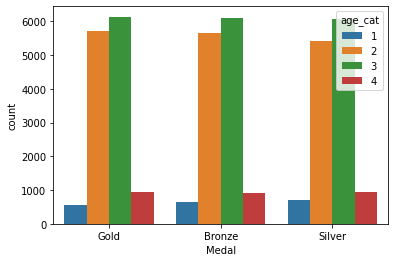

In [82]:
data['age_cat'] = data['Age'].apply(lambda age: 1 if age < 18 else 2 if age < 25 else 3 if age < 35 else 4)
sns.countplot(x='Medal', hue = 'age_cat', data=data.loc[data['Medal']!=0,:])

Еще один рассматривемый тип графиков - boxplot. Данный график удобно применять для анализа распределения количественного признака по категориальным. Для примера оценен возраст спортсменов, завоевавших медали.

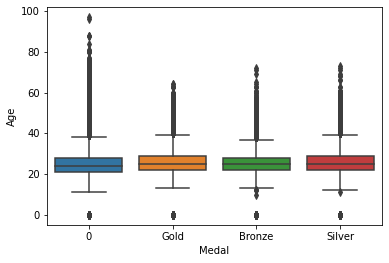

In [83]:
sns.boxplot(x='Medal', y='Age',   data=data);

Стоит обсудить немного подробнее, как же понимать box plot. Box plot состоит из коробки (поэтому он и называется box plot), усиков и точек. Коробка показывает интерквартильный размах распределения, то есть соответственно 25% (Q1) и 75% (Q3) перцентили. Черта внутри коробки обозначает медиану распределения.
С коробкой разобрались, перейдем к усам. Усы отображают весь разброс точек кроме выбросов, то есть минимальные и максимальные значения, которые попадают в промежуток (Q1 - 1.5*IQR, Q3 + 1.5*IQR), где IQR = Q3 - Q1 — интерквартильный размах. Точками на графике обозначаются выбросы (outliers) — те значения, которые не вписываются в промежуток значений, заданный усами графика.


Для понимания лучше один раз увидеть, поэтому вот еще и картинка с Wikipedia:
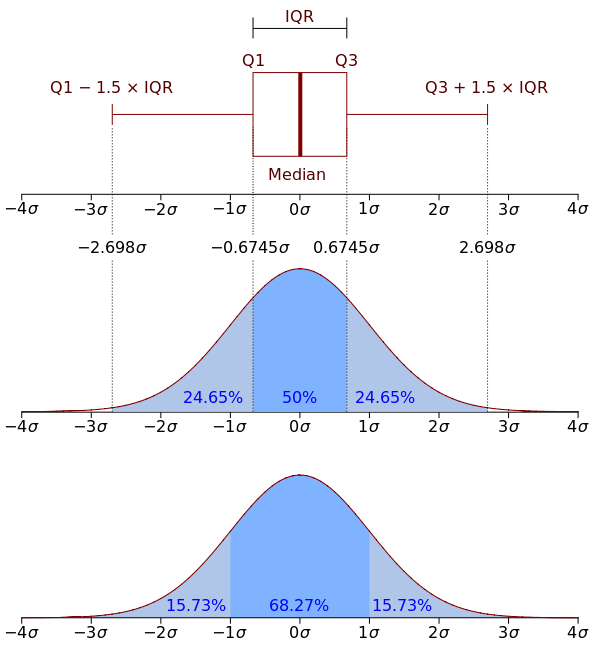

Seaborn может также применяться для оценки распределения величин. На следующем графике представлена оценка распределения возраста для всех спортсменов.

<AxesSubplot:xlabel='Age', ylabel='Density'>

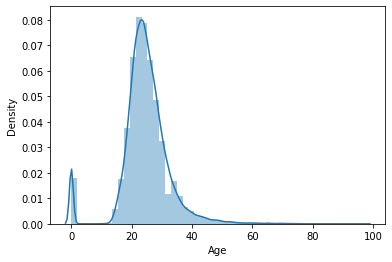

In [7]:
data.fillna(0, inplace = True)
sns.distplot(data.Age)

Еще один график, который позволяет построить библиотека seaborn, это pairplot. Этот графит отображает взаимосвязи в распределении значений разных признаков. График может быть построен для любого количества признаков.

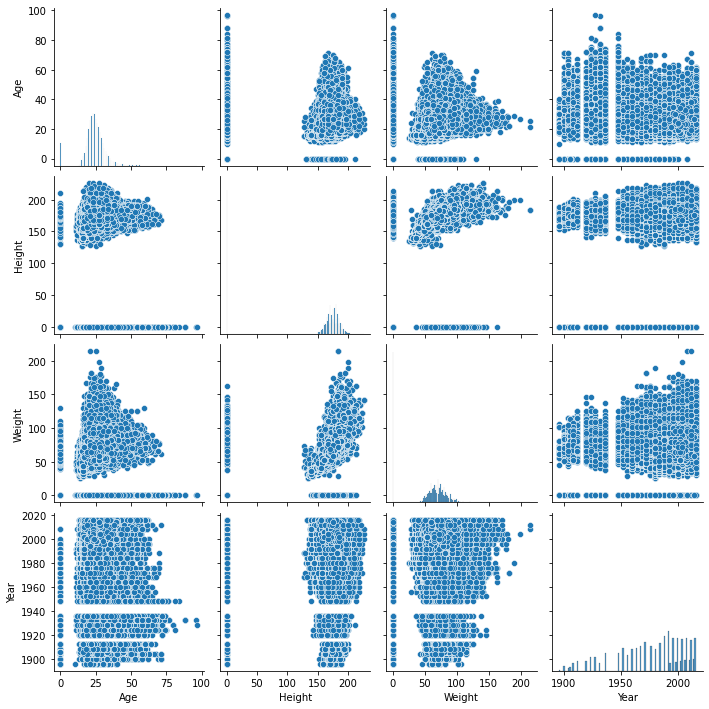

In [ ]:
cols = ['Age', 'Height', 'Weight', 'Year']
sns_plot = sns.pairplot(data[cols])

Как видно из построенного графика - наблюдается некоторая взаимосвязь между возрастом, ростом и весом спортсменов. Например, при увеличении возраста снижается средний вес спортсменов. Также можно заметить, что с годами среднее значение роста и веса спортсменов приблизительно сохранилось. Но отклонение значение от среднего увеличилось.

# Задания для самостоятельного выполнения

## Задание № 1
Построить stackplot, который будет отображать накопление бронзовых медалей командой Великобритании за 1900 - 1960 года.

In [ ]:
medals = data[(data['NOC'] == 'GBR') & (data['Medal'] == 'Bronze') & ((data['Year'] >= 1900)&(data['Year'] <= 1960))]['Year'].value_counts()
years = np.array(medals.sort_index().index)
medals_stack = np.array(medals.sort_index())
medals_temp = np.array(medals.sort_index())
for i in range(1, len(medals_stack)):
    medals_stack[i] = medals_temp[i-1]
    if i>1:
        medals_stack[i] += medals_stack[i-1]
medals_stack[0] = 0
medals_array = np.array([medals.sort_index(), medals_stack])

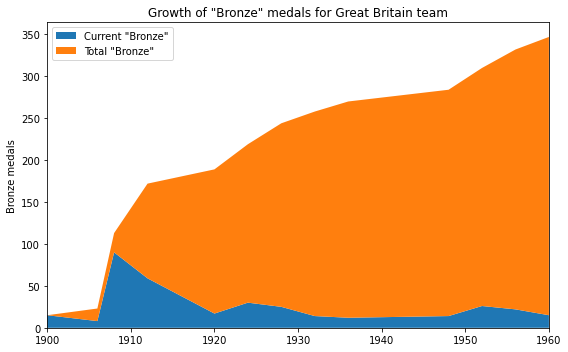

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.stackplot(medals.sort_index().index, medals_array, labels=['Current "Bronze"', 'Total "Bronze"'])
ax.set_title('Growth of "Bronze" medals for Great Britain team')
ax.legend(loc='upper left')
ax.set_ylabel('Bronze medals')
ax.set_xlim(left = medals.index.min(), right = medals.index.max())
fig.tight_layout()
plt.show()

## Задание № 2
Построить три графика, отображающих по годам количество мужчин, участвующих в играх:
1. Учитывать летние и зимние игры.
2. Учитывать только летние игры.
3. УУчитывать только зимние игры.

<AxesSubplot:>

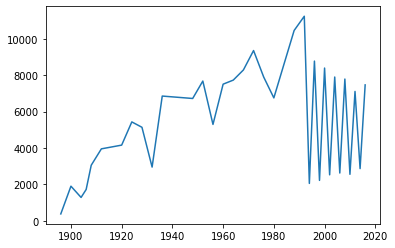

In [ ]:
#Код для графика 1
data[(data['Sex'] == 'M') & ((data['Season'] == 'Summer') | (data['Season'] == 'Winter'))]['Year'].value_counts().sort_index().plot()

<AxesSubplot:>

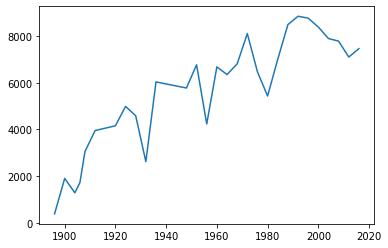

In [ ]:
#Код для графика 2
data[(data['Sex'] == 'M') & (data['Season'] == 'Summer')]['Year'].value_counts().sort_index().plot()

<AxesSubplot:>

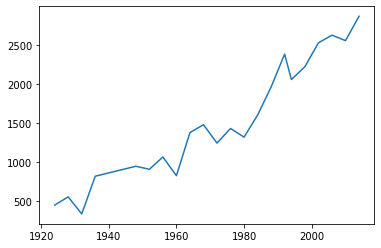

In [ ]:
#Код для графика 3
data[(data['Sex'] == 'M') & (data['Season'] == 'Winter')]['Year'].value_counts().sort_index().plot()

## Задание № 3
Построить график, отображающий по годам количество женщин, участвующих во всех беговых соревнованиях.

<AxesSubplot:>

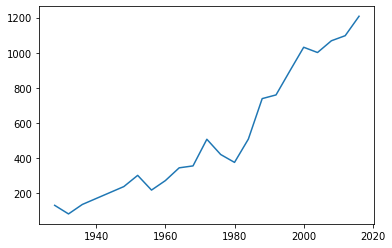

In [ ]:
#Ваш код здесь
data[(data['Sex'] == 'F') & (data['Sport'] == 'Athletics')]['Year'].value_counts().sort_index().plot()

## Задание № 4
Построить график, отображающий по годам количество спортсменов в возрасте от 50 до 60 лет. Учитывать суммарное количество по летним и зимним играм.

<AxesSubplot:>

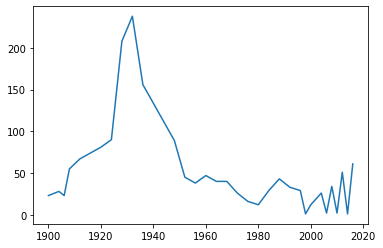

In [ ]:
#Ваш код здесь
data[((data['Season'] == 'Summer')|(data['Season']=='Winter')) & ((data['Age'] >= 50) & (data['Age'] <= 60))]['Year'].value_counts().sort_index().plot()

## Задание № 5
Постройте столбчатую диаграмму, показывающую количество спортсменов с ростом выше 190 по годам. Рассмотреть только зимние игры.

<AxesSubplot:>

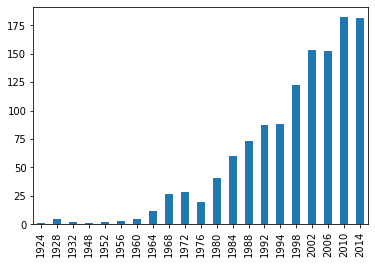

In [ ]:
data[(data['Season']=='Winter') & (data['Height'] >= 190)]['Year'].value_counts().sort_index().plot(kind='bar')

## Задание № 6
Проанализируйте плотность распределение спортсменов с весом свыше 120 с использование графика (density).

<AxesSubplot:ylabel='Density'>

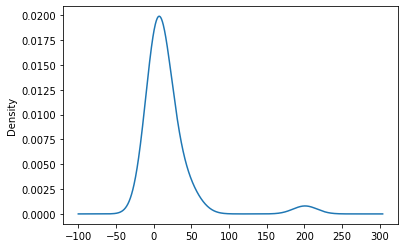

In [ ]:
data[(data['Weight'] > 120)]['Weight'].value_counts().sort_index().plot(kind='density')

<AxesSubplot:xlabel='Weight', ylabel='Density'>

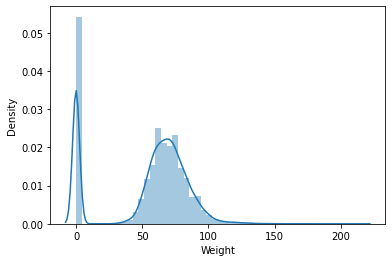

In [181]:
data.fillna(0, inplace = True)
sns.distplot(data.Weight)

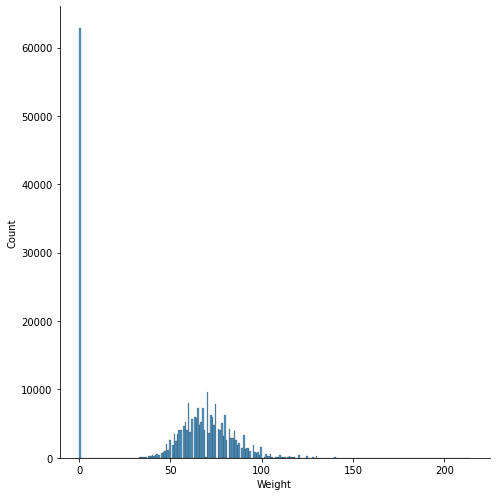

In [185]:
sns.displot(data, x = "Weight",height = 7)

## Задание № 7
Построить график, отражающий количество медалей, завоеванных командами с группировкой по типам медалей. При этом объединить команды URS и RUS (URS - это Код МОК для СССР). График построить только для первых 10 групп (команда/медаль).

<AxesSubplot:xlabel='team_cat', ylabel='count'>

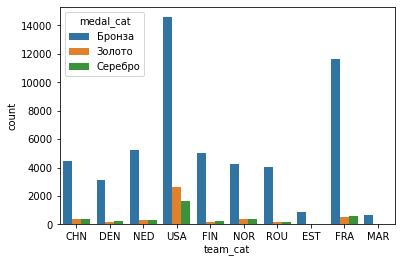

In [14]:
NOC = data['NOC'].unique()[0:10]
data['medal_cat'] = data['Medal'].apply(lambda medal: "Золото" if medal == 'Gold' else "Серебро" if medal == 'Silver' else "Бронза") # медали
data['team_cat'] = data['NOC'].apply(lambda noc: noc if noc in NOC else None) #объединение с СССР (не работает)
sns.countplot(x='team_cat', hue = 'medal_cat', data=data.loc[(data['NOC'] != 0),:])
#NOC
# r = 'CHN'
# if r in NOC:
#     print("YES")
# else:
#     print("NO")

<AxesSubplot:xlabel='team_cat', ylabel='count'>

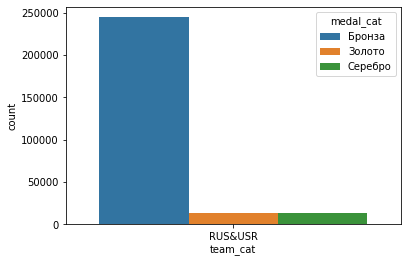

In [11]:
#Ваш код здесь
NOC = data['NOC'].unique()[10:20]
data['medal_cat'] = data['Medal'].apply(lambda medal: "Золото" if medal == 'Gold' else "Серебро" if medal == 'Silver' else "Бронза") 
data['team_cat'] = data['NOC'].apply(lambda noc: "RUS&USR" if (('URS' in NOC)|('RUS' in NOC)) else noc if noc in NOC else None) 
sns.countplot(x='team_cat', hue = 'medal_cat', data=data.loc[(data['NOC'] != 0),:])

#NOC

# d = data['Year'].unique()
# d.sort()
# #создание объекта list с количеством уникальных видов спорта по годам
# uniq_events = []
# for i in range(0, len(d)-1):
#     #Если до 1994 - зимние и летние проводятся в один год
#     if d[i]<1994:
#         uniq_events.append(data[data['Year']==d[i]]['Event'].nunique())
#     else:
#         #После 1994 - зимние и летние приходится складывать
#         for j in range(i, len(d)-1, 2):
#             uniq_events.append(data[data['Year']==d[j]]['Event'].nunique() + data[data['Year']==d[j+1]]['Event'].nunique())
#         break
# #Удаление годов только с зимними играми
# d = np.delete(d, [33, 31, 29, 27, 25, 23])
# events_array = pd.Series(data=uniq_events, index=d, dtype=None, name=None, copy=False, fastpath=False)

<AxesSubplot:xlabel='team_cat', ylabel='count'>

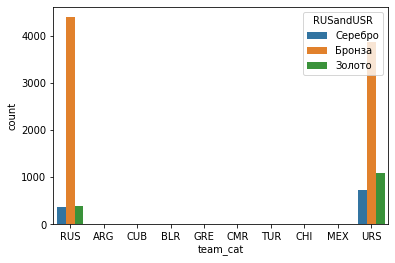

In [15]:
NOC = data['NOC'].unique()[18:28]
filterRUSURS = data['NOC'].isin(['RUS','URS'])
data['RUSandUSR'] = data[filterRUSURS]['Medal'].apply(lambda medal: "Золото" if medal == 'Gold' else "Серебро" if medal == 'Silver' else "Бронза")
data['medal_cat'] = data['Medal'].apply(lambda medal: "Золото" if medal == 'Gold' else "Серебро" if medal == 'Silver' else "Бронза") 
data['team_cat'] = data['NOC'].apply(lambda noc: noc if noc in NOC else None) 
if (("RUS" in NOC)&("URS" in NOC)):
    a = 'RUSandUSR'
    hue = a
else: 
    a = 'medal_cat'
    hue = a
sns.countplot(x='team_cat', hue = a, data=data.loc[(data['NOC'] != 0),:])

## Задание № 8
Построить графики, отображающие количество завоеванных медалей в зависимости от роста и веса. Рост и вес разбить на группы (создать новые признаки). Например, рост разделить на следующие группы: до 155см, до 165 см, до 175 см, до 185 см, свыше 185 см. Можно (даже желательно) придумать свое разбиение на группы.

<AxesSubplot:xlabel='Medal', ylabel='count'>

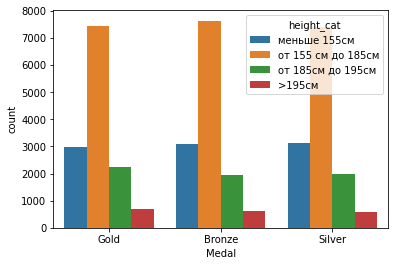

In [ ]:
data['height_cat'] = data['Height'].apply(lambda height: "меньше 155см" if height < 155 else "от 155 см до 185см" if height < 185 else "от 185см до 195см" if height < 195 else ">195см")
sns.countplot(x='Medal', hue = 'height_cat', data=data.loc[data['Medal']!=0,:])

<AxesSubplot:xlabel='Medal', ylabel='count'>

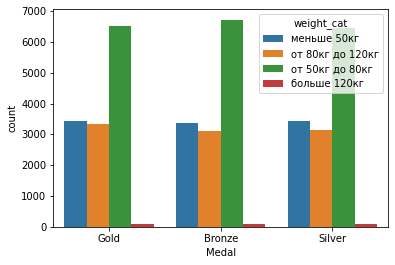

In [ ]:
#Ваш код здесь
data['weight_cat'] = data['Weight'].apply(lambda weight: "меньше 50кг" if weight < 50 else "от 50кг до 80кг" if weight < 80 else "от 80кг до 120кг" if weight<120 else "больше 120кг")
sns.countplot(x='Medal', hue = 'weight_cat', data=data.loc[data['Medal']!=0,:])

## Задание № 9
Найти виды спорта в которых золотых медалей было разыграно больше, чем серебряных. Также найти виды спорта, где серебряных медалей было разыграно больше, чем бронзовых.

In [33]:
data.groupby('Sport')
df1 = (pd.crosstab(data['Sport'], data['Medal']))
df1[df1['Gold']>df1['Silver']].index.values

array(['Aeronautics', 'Alpinism', 'Archery', 'Athletics', 'Basketball',
       'Basque Pelota', 'Bobsleigh', 'Boxing', 'Croquet', 'Equestrianism',
       'Fencing', 'Figure Skating', 'Football', 'Gymnastics', 'Hockey',
       'Judo', 'Luge', 'Motorboating', 'Rowing', 'Rugby Sevens',
       'Sailing', 'Swimming', 'Synchronized Swimming', 'Water Polo',
       'Weightlifting'], dtype=object)

In [34]:
df1[df1['Silver']>df1['Bronze']].index.values

array(['Alpine Skiing', 'Archery', 'Art Competitions', 'Athletics',
       'Basketball', 'Biathlon', 'Cricket', 'Curling', 'Cycling',
       'Equestrianism', 'Fencing', 'Figure Skating', 'Gymnastics',
       'Handball', 'Ice Hockey', 'Lacrosse', 'Polo', 'Rugby', 'Sailing',
       'Shooting', 'Short Track Speed Skating', 'Ski Jumping', 'Softball',
       'Speed Skating', 'Swimming', 'Synchronized Swimming', 'Tug-Of-War'],
      dtype=object)

Ссылки:

https://habr.com/ru/company/ods/blog/323210

https://python-scripts.com/matplotlib#5

Free use is permitted for any non-commercial purpose. No rights reserved.

Gusev Pavel, gusevpvl@gmail.com, 2020